# Techniques of High Performance Computing - Assignment 4

**Name: John Duffy**

**Student Number: 19154676**

# In the Moment of Heat

Reference: The SIAM 100-Digit Challenge: A Study in High-Accuracy Numerical Computing / Folkmar Bourneman ... \[et al.\].

## Program Description

## Program Structure

## Correctness Testing

## Performance Testing

In [58]:
# Import libraries common to all implementations...

import numpy as np
import matplotlib.pyplot as plt

## Gauss-Seidel Iteration - Numba Implementation

The following code implements Gauss-Seidel iterations both upwards and downwards using Numba to improve performance. The functions below are written in as simple 'C' like code as possible to enable just-in-time compilation using the @njit decorator.

In [59]:
# Import numba njit...

from numba import njit

In [60]:
@njit
def gauss_seidel_up_update_row(n, u, v, row):
    """
    This function implements an upwards row iteration. Note the subtle accessing of u and v.
    """
    for col in range(1, n - 1):
        v[row, col] = (v[row + 1, col] + u[row - 1, col] + u[row, col + 1] + u[row, col - 1]) / 4.0

@njit
def gauss_seidel_down_update_row(n, u, v, row):
    """
    This function implements a downwards row iteration. Note the subtle accessing of u and v.
    """
    for col in range(1, n - 1):
        v[row, col] = (u[row + 1, col] + v[row - 1, col] + u[row, col + 1] + u[row, col - 1]) / 4.0

In [61]:
@njit
def gauss_seidel_iteration(n, u, v, direction='up'):
    """
    This function funtion implements an 'up' or 'down' Gauss-Seidel iteration of the input
    vector u, returning the result in vector u. The direction is selection by the named 
    'direction' parameter and the appropriate function is selected based upon the value
    of this parameter.
    """

    if (direction == 'up'):
        for row in range(n - 2, 0, -1):
            gauss_seidel_up_update_row(n, u, v, row)
            
    if (direction == 'down'):
        for row in range(1, n - 1):
            gauss_seidel_down_update_row(n, u, v, row)

    return v

## Correctness Testing - By Hand Calculation

In [62]:
N = 5

# Create a test input vector u setting the boundary conditions.

u = np.zeros((N, N), dtype=np.float64)

u[N - 1, :] = 5.0

# Create the output vector v.

v = np.copy(u)

# Call the Gauss-Seidel iteration function.

gauss_seidel_iteration(N, u, v,)

print(u)
print(v)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [5. 5. 5. 5. 5.]]
[[0.       0.       0.       0.       0.      ]
 [0.       0.078125 0.078125 0.078125 0.      ]
 [0.       0.3125   0.3125   0.3125   0.      ]
 [0.       1.25     1.25     1.25     0.      ]
 [5.       5.       5.       5.       5.      ]]


## Correctness Testing - Visually

In [63]:
# Declare plotting functions.

def plot(v, title, iteration):
    """
    This function...
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(v, extent=[0, 2, 0, 2], origin='upper', cmap='Reds')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Iteration: ' + str(iteration))
    plt.show()


In [64]:
N = 5

# Create a test input vector u setting the boundary conditions.

u = np.zeros((N, N), dtype=np.float64)

u[N - 1, :] = 5.0

# Create the output vector v.

v = np.copy(u)

# Call the Gauss-Seidel iteration function.

gauss_seidel_iteration(N, u, v)

# Plot the results.

#plot(v, 'Gauss-Seidel', 1)

array([[0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.078125, 0.078125, 0.078125, 0.      ],
       [0.      , 0.3125  , 0.3125  , 0.3125  , 0.      ],
       [0.      , 1.25    , 1.25    , 1.25    , 0.      ],
       [5.      , 5.      , 5.      , 5.      , 5.      ]])

## Correctness Testing - Repeated Function Invocations

In [65]:
# Repeated calls to gauss_seidel_iteration() with the result plotted.

N = 32

u = np.zeros((N, N), dtype=np.float64)

u[N - 1, :] = 5.0

v = np.copy(u)

#plot(v, 'Gauss-Seidel', 0)
#
#for i in range(6):
#    gauss_seidel_iteration(N, u, v)
#    plot(v, 'Gauss-Seidel', i + 1)
#    u = v

## Determine T*

In [66]:
#N = [33, 65, 129, 257, 513, 1025]

#N = [513, 1025, 2049]

N = np.array([33, 65, 129], dtype=np.int32)

T = np.zeros((len(N)), dtype=np.int32)

#for i, n in enumerate(N):
#    
#    u = np.zeros((n, n), dtype=np.float64)
#
#    u[n - 1, :] = 5.0
#
#    v = np.copy(u)
#
#    iteration = 0;
#
#    while v[(n - 1) // 2, (n - 1) // 2] < 1.0:
#        gauss_seidel_iteration(n, u, v)
#        iteration += 1
#        u = v
#
#    plot(v, 'Gauss-Seidel ' + 'N = ' + str(n), iteration)
#    
#    T[i] = iteration


#plt.figure(figsize=(12, 8))
#plt.loglog(1.0 / N, T, '-o')
#plt.xlabel('log(h)')
#plt.ylabel('log(Iterations)')
#plt.title('T*')
#plt.grid()
#plt.show()

#np.polyfit(np.log(1.0 / N), np.log(T), 1)

In [67]:
N / 3

array([11.        , 21.66666667, 43.        ])

## Finite Differences

In [68]:
# Import numba...

from numba import njit, prange

### A First Attempt

For a first attempt let's try a first-order forward differences in time and second-order central differences in space discretisation of the problem.

In [69]:
@njit(parallel=True)
def timestep(n, u, c):
    '''
    This function
    '''
    v = np.copy(u)
    for row in range(1, n - 1):
        for col in prange(1, n - 1):
            v[row, col] = u[row, col] - c * (4 * u[row, col] - u[row - 1, col] - u[row + 1, col] - u[row, col - 1] - u[row, col + 1])
    return v

Courant Number: 0.024999999999999994
t:  0.4240000000000003


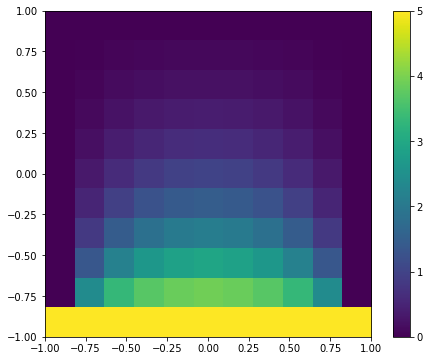

In [70]:
#%%timeit

N = 11
M = 1001

u = np.zeros((N, N), dtype=np.float64)
u[0, :] = 5.0

h = 2.0 / (N - 1)
k = 1.0 / (M - 1)

c = k / h**2

print("Courant Number: {}".format(c))

t = 0.0

while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
    u = timestep(N, u, c)
    t = t + k
    
print("t: ", t)

plt.figure(figsize=(8, 6))
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

### Minimise Rounding Errors

The code above...

Addition and multiplication generally don't reduce precision.

Subtraction and division generally do reduce precision.

General principles for increased precision:

1. Do as much as possible using integer operations
2. Make numbers bigger (addition and multiplication) before making them smaller (subtraction and division).
3. Do as few floating point operations as possible, and do them as late as possible.

Let's refactor it...

This may be slower...

In [71]:
N = 11
M = 1001

In [72]:
@njit(parallel=True)
def timestep(n, u):
    '''
    This function
    '''
    v = np.copy(u)
    for row in range(1, n - 1):
        for col in prange(1, n - 1):
            v[row, col] = u[row, col] - ((N - 1) * (N - 1) * (4 * u[row, col] - u[row - 1, col] - u[row + 1, col] - u[row, col - 1] - u[row, col + 1])) / (4 * (M - 1))
    return v

Courant Number: 0.025
t:  0.424


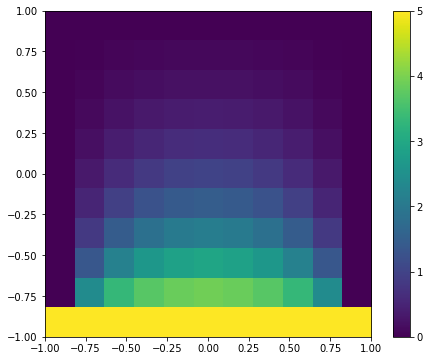

In [73]:
#%%timeit

u = np.zeros((N, N), dtype=np.float64)
u[0, :] = 5.0

print("Courant Number: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

i = 0

while u[(N - 1) // 2, (N - 1) // 2] < 1.0:
    u = timestep(N, u)
    i += 1
      
print("t: ", i / (M - 1))

plt.figure(figsize=(8, 6))
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

### Arbitary Length Arithmetic

The...


In [409]:
N = 1001
M = 1000001

In [410]:
@njit(parallel=True)
def timestep(n, u):
    '''
    This function
    '''
    v = np.copy(u)
    for row in range(1, n - 1):
        for col in prange(1, n - 1):
            v[row, col] = u[row, col] - ((N - 1) * (N - 1) * (4 * u[row, col] - u[row - 1, col] - u[row + 1, col] - u[row, col - 1] - u[row, col + 1])) / (4 * (M - 1))

            #v[row, col] = (u[row - 1, col] + u[row + 1, col] + u[row, col - 1] + u[row, col + 1]) / 4

    return v

In [411]:
#%%timeit

u = np.full((N, N), 1_000_000_000, dtype=np.int32)
u[0, :] = 1_500_000_000
 
print("Courant Number: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))

i = 0

while u[(N - 1) // 2, (N - 1) // 2] < 1_100_000_000:
    u = timestep(N, u)
    i += 1

#u = timestep(N, u)
#u = timestep(N, u)
#u = timestep(N, u)
   
print("t: ", i / (M - 1))

print(u)

plt.figure(figsize=(8, 6))
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

Courant Number: 0.25


KeyboardInterrupt: 

## OpenCL Finite Differences

In [77]:
import pyopencl as cl

In [78]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void finite_differences(const int n, const int m, const int direction, __global float *u, __global float *v, __global float *temperature)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Don't change the boundary conditions.
    
    if (r == 0 || r == n - 1 || c == 0 || c == n - 1) {
        v[n * r + c] = u[n * r + c];
        return;
    } 
    
    // Implement the averaging formula for the interior points.
    
    if (direction == 1) {
        //v[n * r + c] = (u[n * (r + 1) + c] + u[n * (r - 1) + c] + u[n * r + (c + 1)] + u[n * r + (c - 1)]) / 4.0f;

        v[n * r + c] = \
            u[n * r + c] - \
            ((n - 1) * (n - 1) * (4 * u[n * r + c] - u[n * (r - 1) + c] - u[n * (r + 1) + c] - u[n * r + (c - 1)] - u[n * r + (c + 1)])) / (4 * (m - 1));

        if (r == (n - 1) / 2 && c == (n - 1) / 2) {
            temperature[0] = v[n * r + c];  // Centre of the plate. 
        }
    }
    else {
        //u[n * r + c] = (v[n * (r + 1) + c] + v[n * (r - 1) + c] + v[n * r + (c + 1)] + v[n * r + (c - 1)]) / 4.0f;

        u[n * r + c] = \
            v[n * r + c] - \
            ((n - 1) * (n - 1) * (4 * v[n * r + c] - v[n * (r - 1) + c] - v[n * (r + 1) + c] - v[n * r + (c - 1)] - v[n * r + (c + 1)])) / (4 * (m - 1));

        if (r == (n - 1) / 2 && c == (n - 1) / 2) {
            temperature[0] = u[n * r + c];  // Centre of the plate.
        }    
    }
}

"""


# Define the class FiniteDifferences.

class FiniteDifferences:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self._n = n
        self._m = m
        
        
        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 

        # Create input and output buffers, u and v. Both u and v are READ_WRITE. This is because
        # although we always initially copy data into u, we may read the result from u or v.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        self._v = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize * n * n)
        
        
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self._temperature = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.float32).itemsize)


        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().finite_differences


    def copy_u_to_device(self, u):
        """
        This method...        
        """
        cl.enqueue_copy(self._queue, self._u, u)


    def copy_u_from_device(self):
        """
        This method...        
        """
        u = np.zeros((self._n, self._n), dtype=np.float32)

        cl.enqueue_copy(self._queue, u, self._u)            

        return u


    def copy_v_from_device(self):
        """
        This method...        
        """
        v = np.zeros((self._n, self._n), dtype=np.float32)

        cl.enqueue_copy(self._queue, v, self._v)            

        return v


    def copy_temperature_from_device(self):
        """
        This method...        
        """
        temperature = np.zeros((1), dtype=np.float32)

        cl.enqueue_copy(self._queue, temperature, self._temperature)            

        return temperature[0]

           
    def iterate(self, direction=1):
        """
        This method...
        """     
        self._kernel(self._queue, (self._n, self._n), None, np.int32(self._n), np.int32(self._m), np.int32(direction), self._u, self._v, self._temperature)

Courant Number: 0.025
t:  0.424


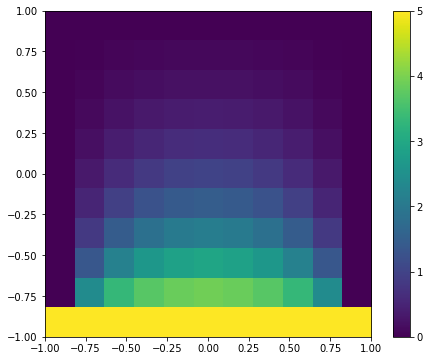

In [80]:
#%%timeit

N = 11
M = 1001

u = np.zeros((N, N), dtype=np.float32)
u[0, :] = 5.0

print("Courant Number: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))


finite_differences = FiniteDifferences(N, M)

finite_differences.copy_u_to_device(u)

i = 0
direction = 1

while True:
    finite_differences.iterate(direction)
    i += 1
    temperature = finite_differences.copy_temperature_from_device()
    if not temperature < 1.0:
        if direction == 1:
            u = finite_differences.copy_v_from_device()
        else:
            u = finite_differences.copy_u_from_device()            
        break
    direction *= -1

print("t: ", i / (M - 1))

plt.figure(figsize=(8, 6))
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1))
plt.colorbar()
plt.show()

## OpenCL Finite Differences - Integer 32

In [433]:
import pyopencl as cl

In [440]:
# Define the OpenCL kernel string used in the class FiniteDifference. It is defined here outside
# of the class for readability, and also so that it may be developed/debugged externally and
# easily included here as part of a build system.

kernel_string = """

__kernel void finite_differences(const int n, const int m, const int direction, __global long *u, __global long *v, __global long *temperature)
{
    // Retrieve the row and column indexes from the global id's.
    
    int r = get_global_id(0);
    int c = get_global_id(1);
    
    // Don't change the boundary conditions.
    
    if (r == 0 || r == n - 1 || c == 0 || c == n - 1) {
        v[n * r + c] = u[n * r + c];
        return;
    } 
    
    // Implement the averaging formula for the interior points.
    
    if (direction == 1) {
        //v[n * r + c] = (u[n * (r + 1) + c] + u[n * (r - 1) + c] + u[n * r + (c + 1)] + u[n * r + (c - 1)]) / 4.0f;

        v[n * r + c] = \
            u[n * r + c] - \
            ((n - 1) * (n - 1) * (4 * u[n * r + c] - u[n * (r - 1) + c] - u[n * (r + 1) + c] - u[n * r + (c - 1)] - u[n * r + (c + 1)])) / (4 * (m - 1));

        if (r == (n - 1) / 2 && c == (n - 1) / 2) {
            temperature[0] = v[n * r + c];  // Centre of the plate. 
        }
    }
    else {
        //u[n * r + c] = (v[n * (r + 1) + c] + v[n * (r - 1) + c] + v[n * r + (c + 1)] + v[n * r + (c - 1)]) / 4.0f;

        u[n * r + c] = \
            v[n * r + c] - \
            ((n - 1) * (n - 1) * (4 * v[n * r + c] - v[n * (r - 1) + c] - v[n * (r + 1) + c] - v[n * r + (c - 1)] - v[n * r + (c + 1)])) / (4 * (m - 1));

        if (r == (n - 1) / 2 && c == (n - 1) / 2) {
            temperature[0] = u[n * r + c];  // Centre of the plate.
        }    
    }
}

"""


# Define the class FiniteDifferences.

class FiniteDifferences:
    """
    This class...
    """
    
    def __init__(self, n, m):
        """
        This constructor...
        """
        
        # Store the n and m as instance variables for access by class methods.
        
        self._n = n
        self._m = m
        
        
        # Create a GPU specific context and command queue.
        
        self._ctx = cl.Context(dev_type = cl.device_type.GPU)
        
        self._queue = cl.CommandQueue(self._ctx, properties=cl.command_queue_properties.PROFILING_ENABLE)
 

        # Create input and output buffers, u and v. Both u and v are READ_WRITE. This is because
        # although we always initially copy data into u, we may read the result from u or v.
 
        self._u = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        self._v = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize * n * n)
        
        
        # Create a buffer to hold the current temperature of the centre of the plate.
        
        self._temperature = cl.Buffer(self._ctx, cl.mem_flags.READ_WRITE, size=np.dtype(np.int64).itemsize)


        # Build the kernel.
        
        self._kernel = cl.Program(self._ctx, kernel_string).build().finite_differences


    def copy_u_to_device(self, u):
        """
        This method...        
        """
        cl.enqueue_copy(self._queue, self._u, u)


    def copy_u_from_device(self):
        """
        This method...        
        """
        u = np.zeros((self._n, self._n), dtype=np.int64)

        cl.enqueue_copy(self._queue, u, self._u)            

        return u


    def copy_v_from_device(self):
        """
        This method...        
        """
        v = np.zeros((self._n, self._n), dtype=np.int64)

        cl.enqueue_copy(self._queue, v, self._v)            

        return v


    def copy_temperature_from_device(self):
        """
        This method...        
        """
        temperature = np.zeros((1), dtype=np.int64)

        cl.enqueue_copy(self._queue, temperature, self._temperature)            

        return temperature[0]

           
    def iterate(self, direction=1):
        """
        This method...
        """     
        self._kernel(self._queue, (self._n, self._n), None, np.int32(self._n), np.int32(self._m), np.int32(direction), self._u, self._v, self._temperature)

Courant Number: 0.0078125
t:  0.4240125


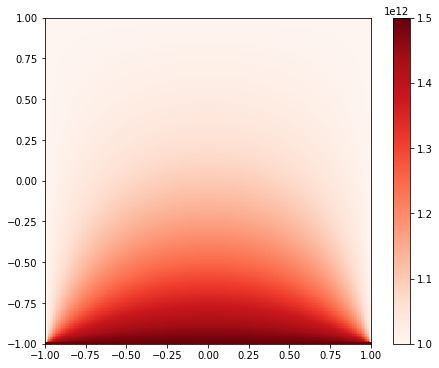

In [481]:
#%%timeit

N = 201
M = 1280001

u = np.full((N, N), 1_000_000_000_000, dtype=np.int64)
u[0, :] = 1_500_000_000_000

print("Courant Number: {}".format(((N - 1) * (N - 1)) / (4 * (M - 1))))


finite_differences = FiniteDifferences(N, M)

finite_differences.copy_u_to_device(u)

i = 0
direction = 1

while True:
    finite_differences.iterate(direction)
    i += 1
    temperature = finite_differences.copy_temperature_from_device()
    if not temperature < 1_100_000_000_000:
        if direction == 1:
            u = finite_differences.copy_v_from_device()
        else:
            u = finite_differences.copy_u_from_device()
        break
    direction *= -1


#finite_differences.iterate(direction)

#u = finite_differences.copy_v_from_device()


print("t: ", i / (M - 1))

plt.figure(figsize=(8, 6))
plt.imshow(u, origin='lower', extent=(-1, 1, -1, 1), cmap='Reds')
plt.colorbar()
plt.show()